In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import matplotlib.pyplot as plt
from matplotlib import patches
import os, sys
import scipy
from joblib import Parallel, delayed
import time
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import cv2

sys.path.append(os.path.abspath('../datacenter/'))
from datacenter.prism import PrismSuperRes
from datacenter.prism.sr_utils import interp_da
from mpl_toolkits.basemap import Basemap, cm
import pandas as pd

In [2]:
# set where the data is located
# some useful functions for data scaling

hr_km = 16
lr_km = 64
data_files = {'DC-Gaussian': '../results/4x/normal_512-512_9-3-5_dc/your-graph/*.nc',
              'Gaussian': '../results/4x/normal_512-512_9-3-5/your-graph/*.nc',
              'DC-Lognormal': '../results/4x/lognormal_512-512_9-3-5/your-graph/*.nc'}      
                
data_keys = ['Gaussian', 'DC-Gaussian', 'DC-Lognormal'] # this is just for ordering
obs_file = '/home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2015.nc'

root = 1
def get_params(dist):
    if dist == 'gamma':
        root = 1.
        scale = 1/100.
    elif dist == 'gaussian':
        root = 1.
        scale = 1./100
    elif dist == 'lognormal':
        root, scale = 1., 1.
    return root, scale

def scale_precip(x, dist):
    root, scale = get_params(dist)
    return (x*scale)**(1./root)

def inverse_scale_precip(x, dist):
    root, scale = get_params(dist)
    return (x**root) / scale

def get_dist(x):
    if 'gaussian' in x.lower():
        return 'gaussian'
    elif 'gamma' in x.lower():
        return 'gamma'
    elif 'lognormal' in x.lower():
        return 'lognormal'

In [3]:
# Read predictions
pred_data = {key: xr.open_mfdataset(data_files[key]) for key in data_files.keys()}
years = np.unique(pred_data['Gaussian']['time.year'].values)
print years

t = np.intersect1d(pred_data['DC-Gaussian'].time.values,
                   pred_data['DC-Lognormal'].time.values)

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2006
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2006.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2007
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2007.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2008
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2008.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2009
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2009.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2010
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2010.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2011
highres file /home/tj/repos/datacenter/datacenter/prism/data/ppt/prism_ppt_4km2_2011.nc
data dir /home/tj/repos/datacenter/datacenter/prism/data/ppt 2012
highres fi

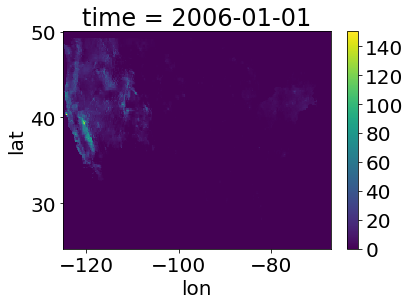

In [4]:
# Read observations and labels
obs = []
inps = []
for y in years:
#for y in [2015]:
    obs_sr = PrismSuperRes('/home/tj/repos/datacenter/datacenter/prism/data/ppt', year=y, var='ppt')
    mask, inp, ob, elev = obs_sr.resolve_data(lr_km=lr_km, hr_km=hr_km)
    obs.append(ob)
    inps.append(inp)

obs = xr.concat(obs, dim='time')
inps = xr.concat(inps, dim='time')
obs.isel(time=0).plot()

In [5]:
# select overlapping times
obs = obs.sel(time=t)
obs_masked = obs * mask.values[0]
for key in pred_data:
    pred_data[key] = pred_data[key].sel(time=t)

# Distribution of Observed

/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


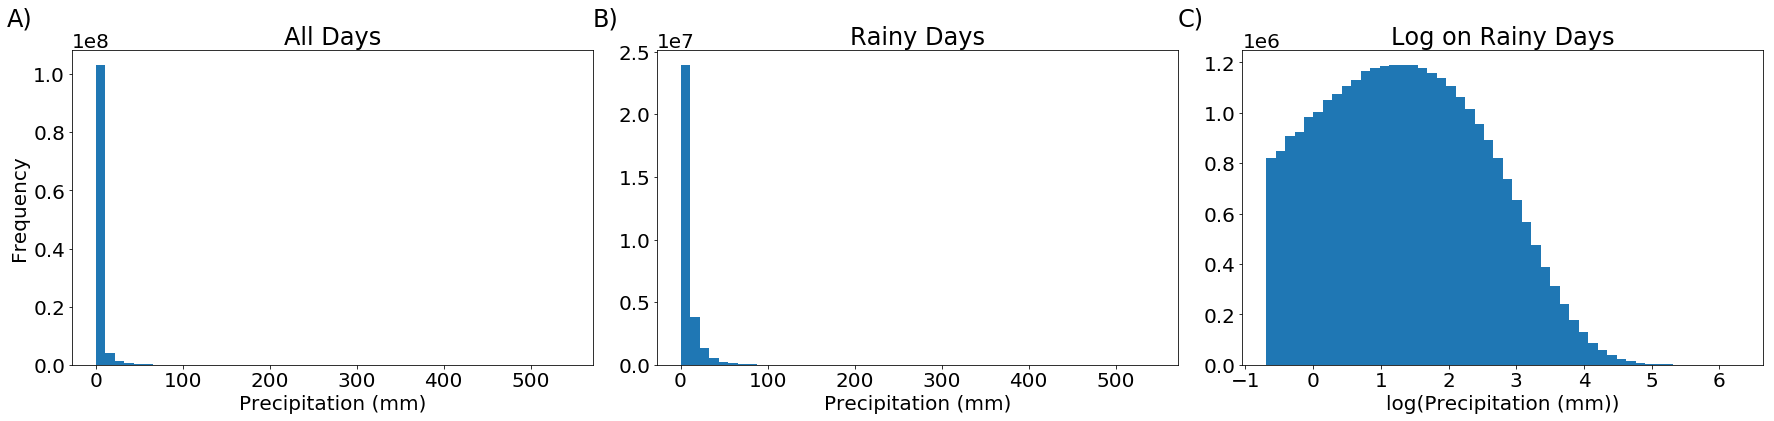

In [6]:
obs_masked = obs * mask.values[0]

y = obs_masked.values.flatten()
y = y[np.isfinite(y) * y>=0]

fig, axs = plt.subplots(1,3, figsize=(25,6))
axs = np.ravel(axs)

axs[0].hist(y, bins=50, density=False)
axs[0].set_title("All Days")
axs[0].set_xlabel("Precipitation (mm)")
axs[0].set_ylabel("Frequency")
axs[0].text(-0.1,1.1, 'A)', horizontalalignment='center', verticalalignment='center',
            transform=axs[0].transAxes, fontsize=24)

axs[1].hist(y[y > 0.5], bins=50, density=False)
axs[1].set_title("Rainy Days")
axs[1].set_xlabel("Precipitation (mm)")
#axs[1].set_ylabel("Frequency")
axs[1].text(-0.1,1.1, 'B)', horizontalalignment='center', verticalalignment='center',
            transform=axs[1].transAxes, fontsize=24)

axs[2].hist(np.log(y[y > 0.5]), bins=50, density=False)
axs[2].set_title("Log on Rainy Days")
axs[2].set_xlabel("log(Precipitation (mm))")
axs[2].ticklabel_format(style='sci',scilimits=(0,0))
axs[2].text(-0.1,1.1, 'C)', horizontalalignment='center', verticalalignment='center',
            transform=axs[2].transAxes, fontsize=24)
#axs[2].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/precip-dist.pdf")
plt.show()

In [7]:

def make_bar_plot(y, title=None):
    hfont = {'fontname':'Helvetica'}
    fig, axs = plt.subplots(1,1, figsize=(12,7))
    axs = np.ravel(axs)
    axs[0].hist(y, bins=20, density=True)
    #axs[0].set_title(title, hfont)
    axs[0].set_xlabel("Precipitation Intensity", hfont)
    axs[0].set_ylabel("Frequency", hfont)
    #axs[0].set_ylim([0,0.04])
    axs[0].set_xlim([min(y),max(y)])
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    # get rid of the frame
    for spine in plt.gca().spines.values():
        #spine.set_linewidth(0.5)
        #spine.set_visible(False)
        spine.set_alpha(0.5)


y_truncated = y[y < 50]
make_bar_plot(y_truncated, title='All Days') 
plt.savefig('figures/hist-alldays.png')
plt.close()

make_bar_plot(y_truncated[y_truncated > 0.5], title='Rainy Days')
plt.savefig('figures/hist-rainydays.png')
plt.close()

make_bar_plot(np.log(y_truncated[y_truncated > 0.5]), title='Log Rainy Days')
plt.savefig('figures/hist-lograiny.png')
plt.close()


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Useful functions

In [8]:
def uq_calibration(observations, dist, p_range):
    ratios  = []
    cdf = dist.cdf(observations)
    zs = []
    for p_interval in p_range:
        p = 0.5 + p_interval / 2.
        plow = 0.5 - p_interval / 2.
        phigh = 0.5 + p_interval / 2.
        ratios.append(np.nanmean((plow < cdf) & (phigh > cdf)))
    return p_range, np.array(ratios)

def calibration(predicted_params, observations, distribution='gaussian',
               rainy_threshold=1.):
    """
    predicted_params: array of shape (N,H,W,2)
    observations: (N,H,W,1)
    """
    y = observations.flatten()
    rainy_days = np.where(y > rainy_threshold)[0]
    y_rainy = y[rainy_days]
    param1 = predicted_params[:,:,:,0].flatten()[rainy_days]
    param2 = predicted_params[:,:,:,1].flatten()[rainy_days]

    p_range = np.arange(0,1.,0.01)
    ratios  = []
    if distribution == 'gaussian':
        dist = scipy.stats.norm(param1, param2)
    elif distribution == 'gamma':
        beta = param1 / param2**2 # beta = E[X] / Var[x] 
        #alpha = beta * param1   # alpha = beta*E[x]
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
        dist = scipy.stats.gamma(param1, loc=0, scale=beta)
    elif distribution == 'lognormal':
        C = param2**2 / param1**2
        s2 = np.log(0.5*np.sqrt(4*C + 1) + 1)
        loc = np.log(param1) - s2 / 2.
        #dist = scipy.stats.lognorm(mu[idxs], std[idxs])
        dist = scipy.stats.lognorm(s2**0.5, scale=np.exp(loc))
    return uq_calibration(y_rainy, dist, p_range)

def plot_rmse(dataxray, ax, title='', vmin=None, vmax=None, colorbar=True, cmap='bwr',
             colorbar_label='mm/day'):
    #data = dataxray['Bias']
    latcorners = np.flipud(dataxray.lat.values)# - 0.5
    loncorners = dataxray.lon.values
    lat_0 = np.median(latcorners) #latcorners.mean()
    lon_0 = np.median(loncorners) #loncorners.mean()
    lt_res = latcorners[1] - latcorners[0]
    ln_res = loncorners[1] - loncorners[0]
    #ax.imshow(dataxray.values, interpolation='nearest', cmap='bwr')
    #return
    # create figure and axes instances

    # create polar stereographic Basemap instance.
    m = Basemap(projection='merc', lat_0=lat_0, lon_0=lon_0, \
                llcrnrlat=latcorners[0],urcrnrlat=latcorners[-1],\
                llcrnrlon=loncorners[0],urcrnrlon=loncorners[-1],\
                resolution='l', ax=ax)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,5.)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=12)
    # draw meridians
    meridians = np.arange(-180,0.,5.)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=12, rotation=30)

    ny = dataxray.shape[0]; nx = dataxray.shape[1]
    lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
    x, y = m(lons, lats) # compute map proj coordinates.
    # draw filled contours.
    #cs = m.contourf(x,y,data,)
    cs = m.imshow(np.flipud(dataxray.values), interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    # add colorbar.
    if colorbar:
        cbar = m.colorbar(cs, location='right', pad="8%")
        if colorbar_label is not None:
            cbar.set_label(colorbar_label, horizontalalignment='right')
    # add title
    if title is not None:
        ax.set_title(title)

# Figure: UQ Calibration

Gaussian gaussian (3652, 152, 348, 2) (3652, 152, 348)


/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


DC-Gaussian gaussian (3652, 152, 348, 2) (3652, 152, 348)
DC-Lognormal lognormal (3652, 152, 348, 2) (3652, 152, 348)


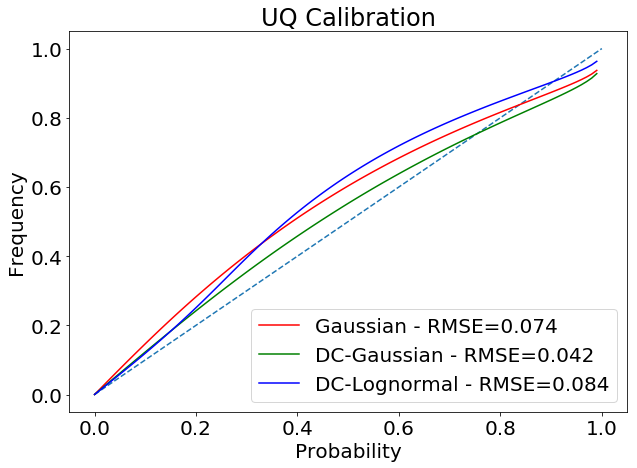

In [9]:


plt.figure(figsize=(10,7))
plt.plot([0,1],[0,1], '--')
colors = ['red', 'green', 'blue']
for i, key in enumerate(data_keys):
    d = get_dist(key)

    params = np.concatenate([pred_data[key]['mu'].values[:,:,:,np.newaxis],  
                             pred_data[key]['sigma'].values[:,:,:,np.newaxis]], axis=-1)
    print key, d, params.shape, obs_masked.shape

    p, q = calibration(params, scale_precip(obs_masked.values[:,:,:,np.newaxis], d), distribution=d,
                      rainy_threshold=scale_precip(0.5, d))
    r = np.mean((p-q)**2)**0.5
    plt.plot(p, q, label='%s - RMSE=%0.3f' % (key, r), color=colors[i])

    
plt.title("UQ Calibration")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("figures/overall-calibration.eps")


# Calibration per Pixel

In [10]:
def _calibration_worker(y_rainy, dist, p_range):
    p, q = uq_calibration(y_rainy, dist, p_range)
    rmse = np.mean((p-q)**2)**0.5
    return rmse
    

def pixel_calibration(predicted_params, observations, distribution='gaussian',
               rainy_threshold=1.):
    """
    predicted_params: array of shape (N,H,W,2)
    observations: (N,H,W,1)
    """
    N, H, W, _ = predicted_params.shape
    workers = []
    indices = []
    for h in range(H):
        for w in range(W):
            y = observations.values[:,h,w].flatten()
            if np.all(np.isnan(y)):
                continue
                
            rainy_days = np.where(y > rainy_threshold)[0]
            y_rainy = y[rainy_days]
            param1 = predicted_params[:,h,w,0].flatten()[rainy_days]
            param2 = predicted_params[:,h,w,1].flatten()[rainy_days]

            p_range = np.arange(0,1.,0.05)
            ratios  = []
            if distribution == 'gaussian':
                dist = scipy.stats.norm(param1, param2)
            elif distribution == 'gamma':
                beta = param1 / param2**2 # beta = E[X] / Var[x] 
                alpha = beta * param1   # alpha = beta*E[x]
                scale = beta
                # UNCLEAR: scale may equal 1/beta or beta 
                # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
                dist = scipy.stats.gamma(param1, loc=0, scale=scale)
            elif distribution == 'lognormal':
                C = param2**2 / param1**2
                s2 = np.log(0.5*np.sqrt(4*C + 1) + 1)
                loc = np.log(param1) - s2 / 2.
                #dist = scipy.stats.lognorm(mu[idxs], std[idxs])
                dist = scipy.stats.lognorm(s2**0.5, scale=np.exp(loc))
            workers.append(delayed(_calibration_worker)(y_rainy, dist, p_range))
            indices.append((h, w))
            

    print "number of workers", len(workers)
    res = Parallel(n_jobs=6)(workers)
    cals = np.empty((H,W))
    cals[:,:] = np.nan
    for i in range(len(indices)):
        cals[indices[i][0], indices[i][1]] = res[i]
        
    da = xr.DataArray(cals, coords=[observations.lat.values, observations.lon],
                      dims=['lat', 'lon'])
    return da

calibration_maps = {}
for key in pred_data.keys():
    params = np.concatenate([pred_data[key]['mu'].values[:,:,:,np.newaxis],  
                             pred_data[key]['sigma'].values[:,:,:,np.newaxis]], axis=-1)
    t = time.time()
    dist = get_dist(key)
    calibration_maps[key] = pixel_calibration(params, scale_precip(obs_masked, dist), distribution=dist, 
                                              rainy_threshold=scale_precip(0.5, dist))

number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

# Figure 2: RMSE Map

In [11]:
# RMSE
rmse_maps = {}
for key in pred_data.keys():
    y = inverse_scale_precip(pred_data[key]['mu'], get_dist(key))
    rmse_maps[key] = ((y - obs_masked)**2).mean('time')**0.5
    print '%s:\t%2.2f' % (key, np.nanmean(rmse_maps[key]))

/home/tj/venvs/my-env/local/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Gaussian:	2.14
DC-Gaussian:	2.07
DC-Lognormal:	2.05


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


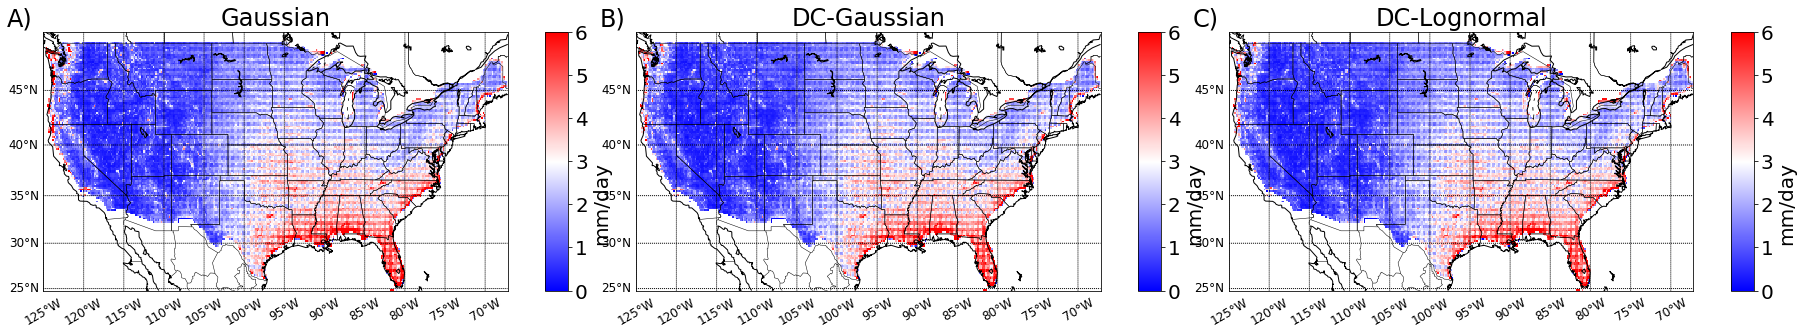

In [12]:
plt.close()
fig, axs = plt.subplots(1,3,figsize=(25,8))
axs = np.ravel(axs)
fig.tight_layout()
plot_rmse(rmse_maps['Gaussian'], axs[0], vmin=0, vmax=6, title='Gaussian', cmap='bwr')
axs[0].text(-0.05,1.05, 'A)', horizontalalignment='center', verticalalignment='center',
            transform=axs[0].transAxes, fontsize=24)
plot_rmse(rmse_maps['DC-Gaussian'], axs[1], vmin=0, vmax=6, title='DC-Gaussian', cmap='bwr')
axs[1].text(-0.05,1.05, 'B)', horizontalalignment='center', verticalalignment='center',
            transform=axs[1].transAxes, fontsize=24)
plot_rmse(rmse_maps['DC-Lognormal'], axs[2], vmin=0, vmax=6, title='DC-Lognormal', cmap='bwr')
axs[2].text(-0.05,1.05, 'C)', horizontalalignment='center', verticalalignment='center',
            transform=axs[2].transAxes, fontsize=24)
plt.tight_layout()
plt.savefig("figures/rmse-maps.pdf", bbox_inches='tight', pad_inches=1.)
plt.show()

# Table 1: Predictive Ability w/ Climdex Indicies

In [13]:
def daily_intensity_index(da, wet_min=0.5):
    wd = (da >= wet_min).resample('AS', 'time', how='sum')
    precip = da.resample('AS', 'time', how='sum')
    res = precip / wd
    return res

def wet_days(dr, wet_min=20.):
    wd = dr >= wet_min
    return wd.resample('AS', 'time', how='sum')

def compute_stats(da, obs, name):
    res = dict()
    rmse = (((da - obs_masked)**2).mean('time')**0.5).values
    res['rmse-mean'] = np.nanmean(rmse)
    res['rmse-std'] = np.nanstd(rmse)
    
    bias = (da-obs_masked).mean('time').values
    res['bias-mean'] = np.nanmean(bias)
    res['bias-std'] = np.nanstd(bias)
    
    sdii = daily_intensity_index(da).mean('time')
    sdii_obs = daily_intensity_index(obs).mean('time')
    sdii_diff = (sdii - sdii_obs).values.flatten()
    sdii_diff = sdii_diff[np.isfinite(sdii_diff)]
    res['sdii-mean'] = np.mean(sdii_diff)
    res['sdii-std'] = np.std(sdii_diff)
    
    r20 = wet_days(da).mean('time').values
    r20_obs = wet_days(obs).mean('time').values
    res['r20-mean'] = (r20 - r20_obs).mean()
    res['r20-std'] = (r20 - r20_obs).std()
    res['name'] = name
    return res

tab1 = []
tab1.append(compute_stats(inverse_scale_precip(pred_data['Gaussian']['mu'], get_dist('Gaussian')), obs_masked, 'Gaussian'))
tab1.append(compute_stats(inverse_scale_precip(pred_data['DC-Gaussian']['mu'], get_dist('DC-Gaussian')), obs_masked, 'DC-Gaussian'))
#tab1.append(compute_stats(inverse_scale_precip(pred_data['DC-Lognormal']['mu'], 'gamma'), obs_masked, 'DC-Lognormal'))
tab1.append(compute_stats(inverse_scale_precip(pred_data['DC-Lognormal']['mu'], get_dist('DC-Lognormal')), obs_masked, 'DC-Lognormal'))

tab1 = pd.DataFrame(tab1).set_index('name')
tab1_latex = tab1[['bias-mean', 'bias-std', 'rmse-mean', 'rmse-std', 'r20-mean', 'r20-std', 'sdii-mean', 'sdii-std']].to_latex(float_format='{:,.2f}'.format)
print tab1_latex

/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="AS").sum() 
  
/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="AS").sum() 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in divide
  return func(*args2)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  bias-mean &  bias-std &  rmse-mean &  rmse-std &  r20-mean &  r20-std &  sdii-mean &  sdii-std \\
name         &            &           &            &           &           &          &            &           \\
\midrule
Gaussian     &      -0.11 &      0.34 &       2.14 &      1.31 &     -0.73 &     1.94 &      -0.83 &      0.93 \\
DC-Gaussian  &      -0.11 &      0.30 &       2.07 &      1.28 &     -0.61 &     1.67 &      -0.21 &      0.78 \\
DC-Lognormal &      -0.02 &      0.30 &       2.05 &      1.27 &     -0.36 &     1.63 &      -0.28 &      0.81 \\
\bottomrule
\end{tabular}



# Figure 3: Calibration Maps

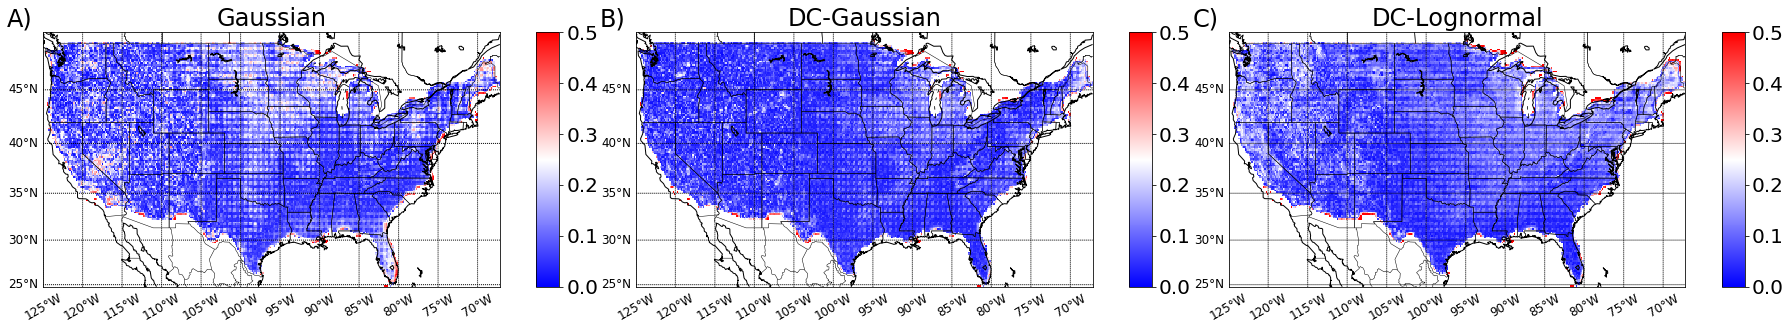

In [14]:
fig, axs = plt.subplots(1,3,figsize=(25,8))
axs = np.ravel(axs)
fig.tight_layout()

plot_rmse(calibration_maps['Gaussian'], axs[0], vmin=0, vmax=0.5, title='Gaussian', cmap='bwr', colorbar_label=None)
axs[0].text(-0.05,1.05, 'A)', horizontalalignment='center', verticalalignment='center',
            transform=axs[0].transAxes, fontsize=24)
plot_rmse(calibration_maps['DC-Gaussian'], axs[1], vmin=0, vmax=0.5, title='DC-Gaussian', cmap='bwr', colorbar_label=None)
axs[1].text(-0.05,1.05, 'B)', horizontalalignment='center', verticalalignment='center',
            transform=axs[1].transAxes, fontsize=24)
plot_rmse(calibration_maps['DC-Lognormal'], axs[2], vmin=0, vmax=0.5, title='DC-Lognormal', cmap='bwr', colorbar_label=None)
axs[2].text(-0.05,1.05, 'C)', horizontalalignment='center', verticalalignment='center',
            transform=axs[2].transAxes, fontsize=24)
plt.savefig("figures/calibration-maps.pdf", bbox_inches='tight', pad_inches=1.)
plt.show()


number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

number of workers 30036


/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tj/venvs/my-env/

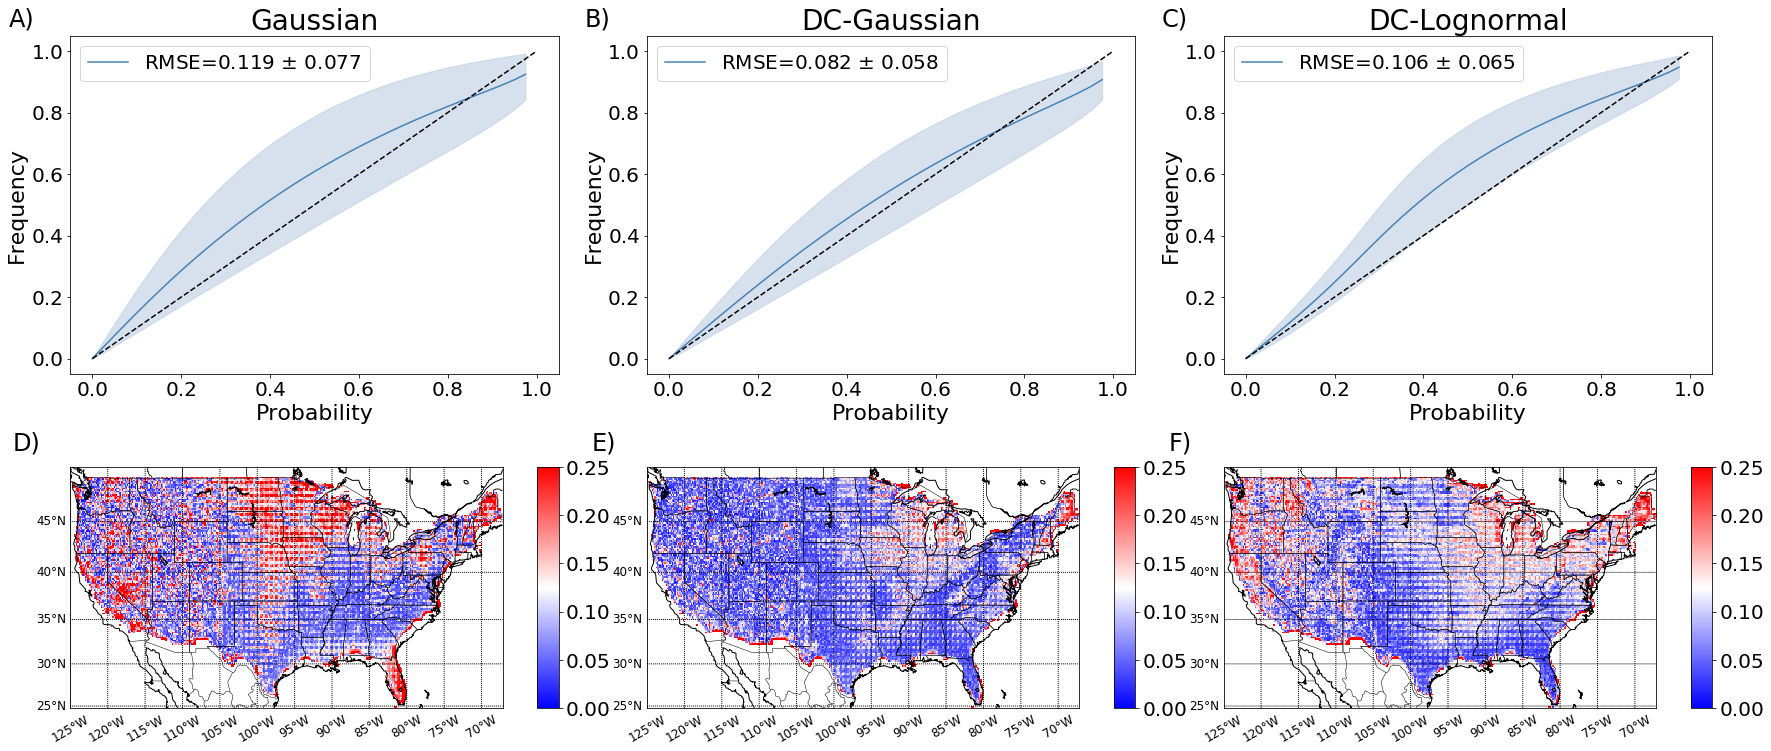

In [15]:
def pixel_calibration_2(predicted_params, observations, distribution='gaussian',
               rainy_threshold=1.):
    """
    predicted_params: array of shape (N,H,W,2)
    observations: (N,H,W,1)
    """
    N, H, W, _ = predicted_params.shape
    #H = 50
    #W = 50
    workers = []
    indices = []
    for h in range(H):
        for w in range(W):
            y = observations.values[:,h,w].flatten()
            if np.all(np.isnan(y)):
                continue
                
            rainy_days = np.where(y > rainy_threshold)[0]
            y_rainy = y[rainy_days]
            param1 = predicted_params[:,h,w,0].flatten()[rainy_days]
            param2 = predicted_params[:,h,w,1].flatten()[rainy_days]

            p_range = np.arange(0,1.,0.025)
            ratios  = []
            if distribution == 'gaussian':
                dist = scipy.stats.norm(param1, param2)
            elif distribution == 'lognormal':
                C = param2**2 / param1**2
                s2 = np.log(0.5*np.sqrt(4*C + 1) + 1)
                loc = np.log(param1) - s2 / 2.
                #dist = scipy.stats.lognorm(mu[idxs], std[idxs])
                dist = scipy.stats.lognorm(s2**0.5, scale=np.exp(loc))
            workers.append(delayed(uq_calibration)(y_rainy, dist, p_range))
            indices.append((h, w))
            
            #if len(workers) > 100:
            #    break
                
    print "number of workers", len(workers)
    res = Parallel(n_jobs=6)(workers)
    cals = np.empty((H, W, 2, len(res[0][0])))
    cals[:] = np.nan
    for i in range(len(indices)):
        cals[indices[i][0], indices[i][1], 0] = res[i][0]
        cals[indices[i][0], indices[i][1], 1] = res[i][1]
    
    cals = np.reshape(cals, (H*W, 2, cals.shape[3]))
    mu = np.nanmean(cals, axis=0).T
    p = mu[:,0]
    q = mu[:,1]
    
    low = np.nanpercentile(cals, 10., axis=0)[1]
    high = np.nanpercentile(cals, 90., axis=0)[1]
    
    rmses = np.nanmean((cals[:,1] - cals[:,0])**2, axis=1)**0.5
    return p, q, low, high, rmses

fig, axs = plt.subplots(2,3,figsize=(25,11))
axs = np.ravel(axs)

uqs = {}
plot_labels = ['A)', 'B)', 'C)']
for i, key in enumerate(pred_data.keys()):
    params = np.concatenate([pred_data[key]['mu'].values[:,:,:,np.newaxis],  
                             pred_data[key]['sigma'].values[:,:,:,np.newaxis]], axis=-1)
    t = time.time()
    dist = get_dist(key)
    p, q, low, high, rmses = pixel_calibration_2(params, scale_precip(obs_masked, dist), distribution=dist, 
                                              rainy_threshold=scale_precip(0.5, dist))
    
    r = np.nanmean(rmses)
    rs = np.nanstd(rmses)
    
    axs[i].plot(p, q, color='steelblue', label='RMSE=%0.3f $\pm$ %0.3f' % (r, rs))
    axs[i].plot([0,1],[0,1], '--', color='black')
    #plt.plot(p, low)
    #plt.plot(p, high)
    axs[i].fill_between(p, low, high, alpha=0.5, color='lightsteelblue')#colors[i])
    axs[i].legend()
    #plt.plot(cals[:,0].T, cals[:,1].T, color='blue', alpha=0.05)
    axs[i].set_title(key, fontsize=28)
    axs[i].set_xlabel("Probability", fontsize=22)
    axs[i].set_ylabel("Frequency", fontsize=22)
    axs[i].text(-0.1, 1.05, plot_labels[i], horizontalalignment='center', verticalalignment='center',
                transform=axs[i].transAxes, fontsize=24)

    
plot_rmse(calibration_maps['Gaussian'], axs[3], vmin=0, vmax=0.25, title='', cmap='bwr', colorbar_label=None)
axs[3].text(-0.1,1.1, 'D)', horizontalalignment='center', verticalalignment='center',
            transform=axs[3].transAxes, fontsize=24)
plot_rmse(calibration_maps['DC-Gaussian'], axs[4], vmin=0, vmax=0.25, title='', cmap='bwr', colorbar_label=None)
axs[4].text(-0.1,1.1, 'E)', horizontalalignment='center', verticalalignment='center',
            transform=axs[4].transAxes, fontsize=24)
plot_rmse(calibration_maps['DC-Lognormal'], axs[5], vmin=0, vmax=0.25, title='', cmap='bwr', colorbar_label=None)
axs[5].text(-0.1,1.1, 'F)', horizontalalignment='center', verticalalignment='center',
            transform=axs[5].transAxes, fontsize=24)

    
fig.tight_layout()
plt.savefig('figures/uq-calibrations.pdf')
plt.show()

# Table 2: Calibration Stats

In [16]:
def calibration_stats(name):
    res = dict(name=name)
    res['rmse-mean'] = calibration_maps[name].mean().values
    res['rmse-std'] = calibration_maps[name].std().values
    return res

tab2 = []
tab2.append(calibration_stats('Gaussian'))
tab2.append(calibration_stats('DC-Gaussian'))
tab2.append(calibration_stats('DC-Lognormal'))
tab2 = pd.DataFrame(tab2).set_index('name')
tab2_latex = tab2.to_latex(float_format='{:,.2f}'.format)
print tab2_latex

\begin{tabular}{lll}
\toprule
{} &            rmse-mean &             rmse-std \\
name         &                      &                      \\
\midrule
Gaussian     &  0.11816568735003773 &  0.07662704414439993 \\
DC-Gaussian  &  0.08126558137245415 &  0.05760347236245707 \\
DC-Lognormal &  0.10614215899196568 &  0.06517987973008112 \\
\bottomrule
\end{tabular}



# Figure 4: Classification PR Curve

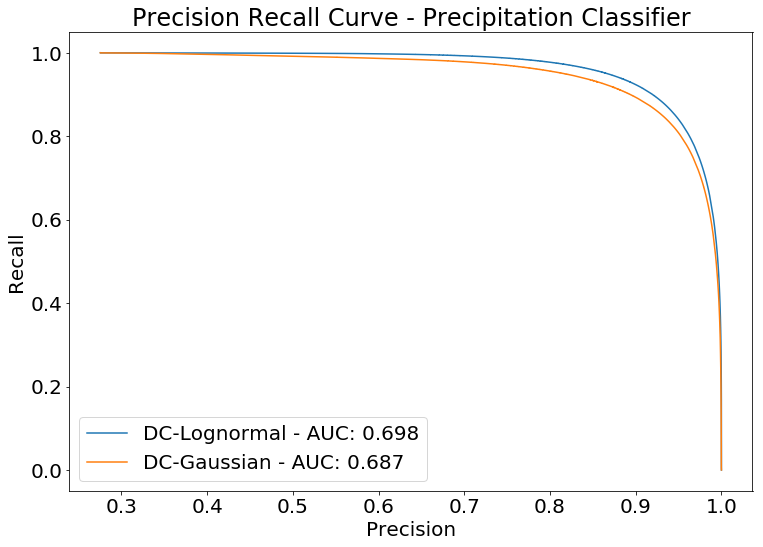

In [17]:
# lets compute accuracies and roc curves
#for key in data_keys:
def get_accuracy(obs, pred, thres):
        return
    
plt.figure(figsize=(11,8))
for key in ['DC-Lognormal', 'DC-Gaussian']:
    probs = pred_data[key]['probs'].values
    p = probs.flatten()
    p = p[np.isfinite(p)]
    
    y = obs_masked.values.flatten()
    y = y[np.isfinite(y)]
    labels = y > 0.5
    
    pr, recall, _ = precision_recall_curve(labels, p)
    area = auc(pr, recall, reorder=True)
    plt.plot(pr, recall, label='%s - AUC: %0.3f' % (key, area))
    
plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("Precision Recall Curve - Precipitation Classifier")
plt.tight_layout()
plt.savefig("figures/pr-curve.eps")
plt.show()

# Low- to High-res Figure

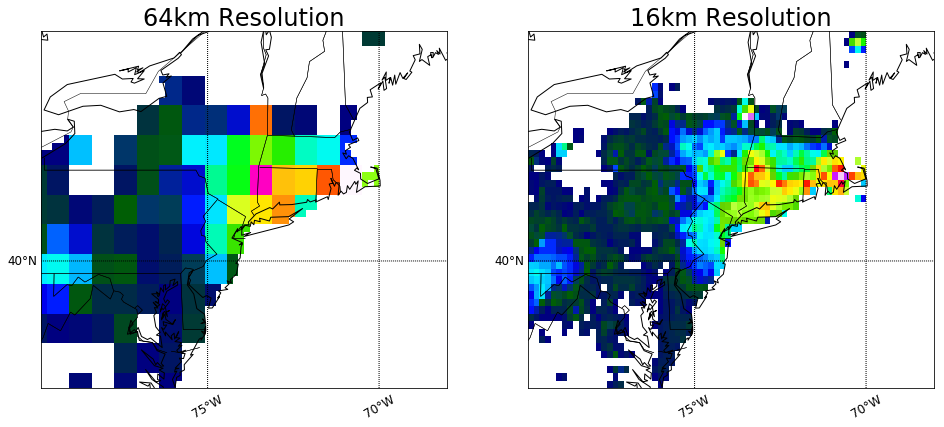

In [18]:
inp_masked = interp_da(inps, 4., how=cv2.INTER_NEAREST) * mask.values[0,:,:]
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs = np.ravel(axs)

lll = (inp_masked / inp_masked) * inp_masked # this makes all 0's nans
rrr = (obs_masked / obs_masked) * obs_masked # this makes all 0's nans
s = inp_masked.std(['lat', 'lon'])
#t = s.time[s.argmax()]
t = s.time[3]

plot_rmse(lll.loc[t].sel(lat=slice(45,37), lon=slice(-80,-68)), axs[0], 
          title='64km Resolution', cmap='gist_ncar', colorbar=False)
plot_rmse(rrr.loc[t].sel(lat=slice(45,37), lon=slice(-80,-68)), axs[1], 
          title='16km Resolution', cmap='gist_ncar', colorbar=False)
#plt.tight_layout()
plt.savefig('figures/example-pair.pdf')
plt.show()

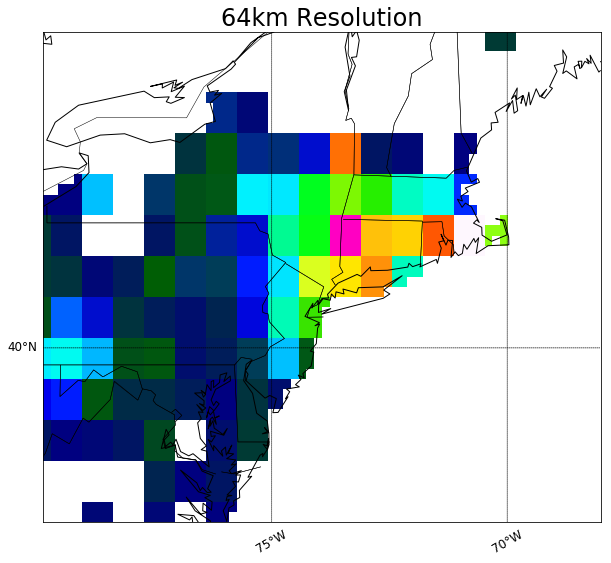

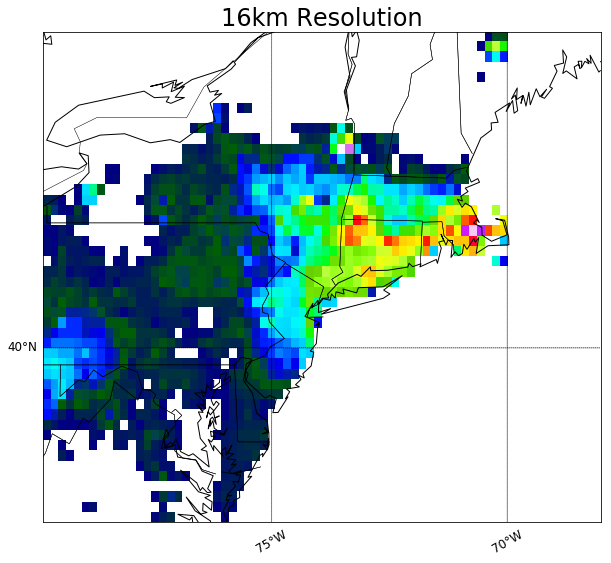

In [19]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs = np.ravel(axs)

plot_rmse(lll.loc[t].sel(lat=slice(45,37), lon=slice(-80,-68)), axs[0], 
          title='64km Resolution', cmap='gist_ncar', colorbar=False)
plt.show()

fig, axs = plt.subplots(1,1, figsize=(10,10))
axs = np.ravel(axs)
plot_rmse(rrr.loc[t].sel(lat=slice(45,37), lon=slice(-80,-68)), axs[0], 
          title='16km Resolution', cmap='gist_ncar', colorbar=False)
plt.show()

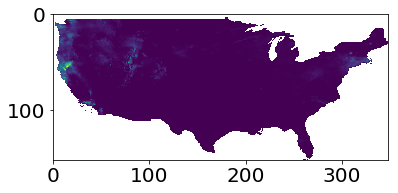

In [20]:
plt.imshow(obs_masked.loc[t])

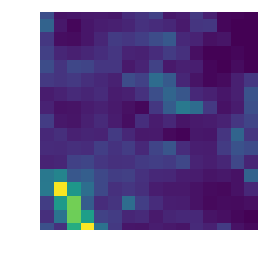

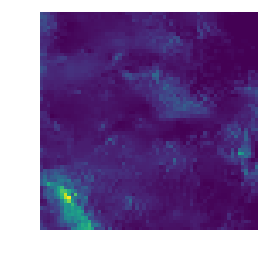

<xarray.DataArray (lat: 152, lon: 348)>
array([[0.000000e+00, 3.357945e-01, 3.403504e+01, ..., 2.942399e+02,
        1.827154e+02, 7.984991e+01],
       [3.400892e+01, 0.000000e+00, 2.873251e+01, ..., 2.917504e+02,
        2.877612e+02, 1.007523e-01],
       [3.744943e+02, 2.533332e+01, 6.287167e+00, ..., 2.413485e+02,
        1.068302e+02, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])
Coordinates:
  * lat      (lat) float64 49.94 49.77 49.6 49.44 49.27 49.1 48.94 48.77 ...
  * lon      (lon) float64 -125.0 -124.9 -124.7 -124.5 -124.4 -124.2 -124.0 ...


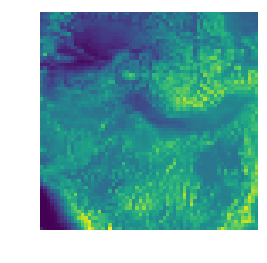

In [21]:
plt.imshow(lll.fillna(0).values[0,10:74,20:84])
plt.axis('off')
plt.show()
plt.imshow(rrr.fillna(0).values[0,10:74,20:84])
plt.axis('off')
plt.show()
print elev
plt.imshow(elev.values[10:74,20:84])
plt.axis('off')
plt.show()

# How much uncertainty is there?

Gaussian


/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/tj/venvs/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


Dc-Gaussian
Dc-Lognormal


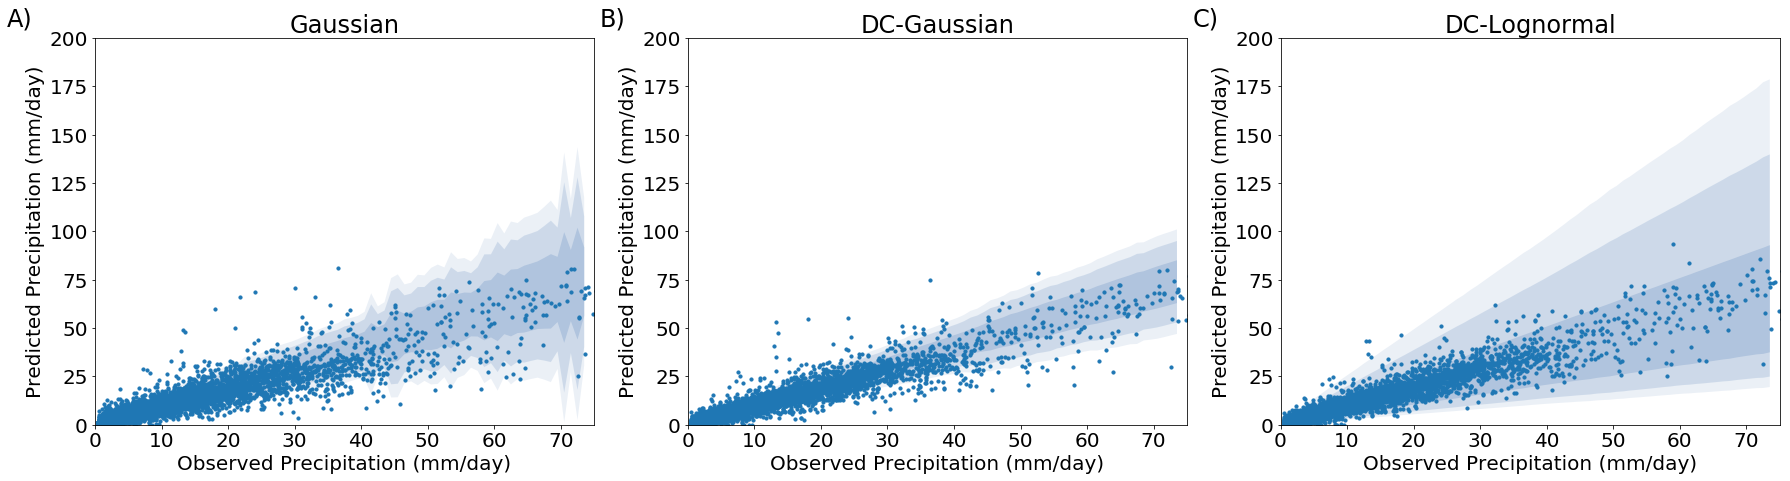

In [22]:
def make_poly(x, y1, y2):
    xy = np.empty([x.shape[0]*2, 2])
    xy[:x.shape[0],0] = x
    xy[x.shape[0]:,0] = x[::-1]
    xy[:x.shape[0],1] = y1
    xy[x.shape[0]:,1] = y2[::-1]
    return xy

fig, axs = plt.subplots(1,3,figsize=(25,7))
axs = np.ravel(axs)
for j, key in enumerate(data_keys):
    print key.title()
    y = obs_masked.values.flatten()
    mu = pred_data[key]['mu'].values.flatten()
    std = pred_data[key]['sigma'].values.flatten()
    std = std[np.isfinite(y) * (y > 0.5)]
    mu = mu[np.isfinite(y) * (y > 0.5)]
    y = y[np.isfinite(y) * (y > 0.5)]

    # now lets loop through bins
    xr = np.arange(0.5, 75., step=1)
    #qs = [0.025, 0.05, 0.10, 0.25, 0.75, 0.9, 0.95,0.975]
    qs = [0.05,.10,.25,0.75, 0.90, 0.95]
    Q = np.empty((len(xr)-1, len(qs)))
    dist_name = get_dist(key)
    pred = inverse_scale_precip(mu, dist_name)
    #axs[j+3].xscale('log')
    for i in range(1,len(xr)):
        idxs = np.where((pred >= xr[i-1]) * (pred < xr[i]))[0][:1000]
        if 'gaussian' in key.lower():
            dist = scipy.stats.norm(mu[idxs], std[idxs])
        elif 'gamma' in key.lower():
            beta = mu[idxs] / std[idxs]**2 # beta = E[X] / Var[x] 
            alpha = beta * mu[idxs]  # alpha = beta*E[x]
            scale = beta
            # UNCLEAR: scale may equal 1/beta or beta 
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            dist = scipy.stats.gamma(mu[idxs], loc=0, scale=scale)
        elif 'lognormal' in key.lower():
            C = std[idxs]**2 / mu[idxs]**2
            s2 = np.log(0.5*np.sqrt(4*C + 1) + 1)
            loc = np.log(mu[idxs]) - s2 / 2.
            #dist = scipy.stats.lognorm(mu[idxs], std[idxs])
            dist = scipy.stats.lognorm(s2**0.5, scale=np.exp(loc))
            
        t = time.time()
        ppfs = [inverse_scale_precip(dist.ppf(q), dist_name)[np.newaxis] for q in qs]
        Q[i-1] = np.concatenate(ppfs, axis=0).mean(axis=1)
    
    poly = patches.Polygon(make_poly(xr[:-1], Q[:,0], Q[:,5]), facecolor='lightsteelblue', edgecolor=None, alpha=0.25)
    axs[j].add_patch(poly)

    poly = patches.Polygon(make_poly(xr[:-1], Q[:,1], Q[:,4]), facecolor='lightsteelblue', edgecolor=None, alpha=0.5)
    axs[j].add_patch(poly)

    poly = patches.Polygon(make_poly(xr[:-1], Q[:,2], Q[:,3]), facecolor='lightsteelblue', edgecolor=None)
    axs[j].add_patch(poly)

    #axs[j].plot(xr[:-1], Q[:,0], label="25 Percentile")
    #axs[j].plot(xr[:-1], Q[:,1], label="75 Percentile")
    #axs[j].plot([0, xr.max()], [0, xr.max()], ls='--')
    axs[j].scatter(y[:10000], pred[:10000], s=10, zorder=2)
    #axs[j].set_xscale("log", nonposx='clip')
    #axs[j].set_yscale("log", nonposx='clip')
    axs[j].set_xlim([0,75])
    axs[j].set_ylim([0,200])
    axs[j].set_title(key)
    axs[j].set_xlabel("Observed Precipitation (mm/day)")
    axs[j].set_ylabel("Predicted Precipitation (mm/day)")
    axs[j].legend()
axs[0].text(-0.15,1.05, 'A)', horizontalalignment='center', verticalalignment='center',
    transform=axs[0].transAxes, fontsize=24)
axs[1].text(-0.15,1.05, 'B)', horizontalalignment='center', verticalalignment='center',
    transform=axs[1].transAxes, fontsize=24)
axs[2].text(-0.15,1.05, 'C)', horizontalalignment='center', verticalalignment='center',
    transform=axs[2].transAxes, fontsize=24)
plt.tight_layout()
plt.savefig("figures/uq-intervals.pdf")
plt.show()

# Lets look at a couple outputs

/home/tj/venvs/my-env/local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1900: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/tj/venvs/my-env/local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


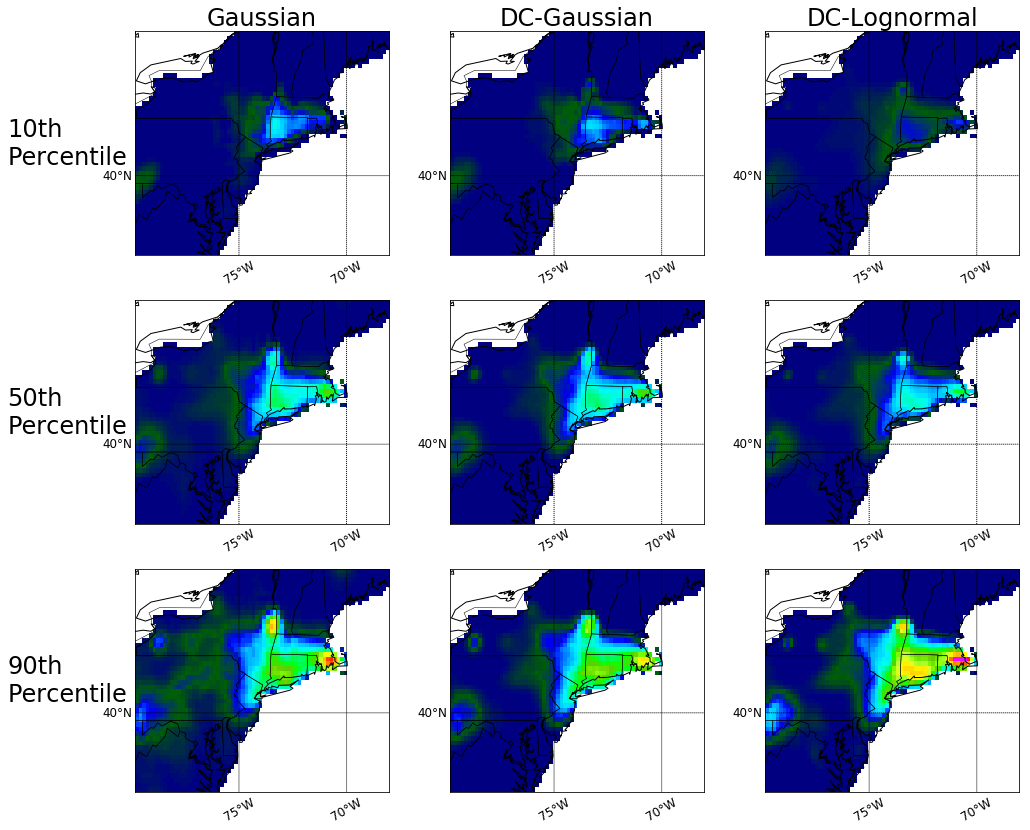

In [23]:
import xarray as xr
k = 'DC-Gaussian'
obs_slice = obs_masked.sel(lat=slice(45,37), lon=slice(-80,-68))
t = 3#np.argmax(np.nanmean(obs_slice.values, axis=(1,2)))
fig, axs = plt.subplots(3,3, figsize=(16,14))
    
for i, k in enumerate(data_keys):
    da = pred_data[k].sel(lat=slice(45,37), lon=slice(-80,-68)).isel(time=t)
    
    param1 = da['mu'].values
    param2 = da['sigma'].values
    probs = da['probs'].values

    if 'gaussian' in k.lower():
        dist = scipy.stats.norm(param1, param2)
        d = 'gaussian'
    else:
        C = param2**2 / param1**2
        s2 = np.log(0.5*np.sqrt(4*C + 1) + 1)
        loc = np.log(param1) - s2 / 2.
        #dist = scipy.stats.lognorm(mu[idxs], std[idxs])
        dist = scipy.stats.lognorm(s2**0.5, scale=np.exp(loc))
        d = 'lognormal'
    
    def stat_to_da(stat):
        return xr.DataArray(stat, coords=[da.lat, da.lon], 
                            dims=['lat', 'lon'])
            
    median = stat_to_da(inverse_scale_precip(dist.ppf(.5)*probs, d))
    low = stat_to_da(inverse_scale_precip(dist.ppf(.10)*probs, d))
    high = stat_to_da(inverse_scale_precip(dist.ppf(.90)*probs, d))    

    plot_rmse(low, axs[0,i], 
          title=k, cmap='gist_ncar', colorbar=False, vmin=0, vmax=50)
    
    plot_rmse(median, axs[1,i], 
          title='', cmap='gist_ncar', colorbar=False, vmin=0, vmax=50)
    
    plot_rmse(high, axs[2,i], 
          title='', cmap='gist_ncar', colorbar=False, vmin=0, vmax=50)

axs[0,0].text(-0.5, 0.5, "10th\nPercentile", horizontalalignment='left', verticalalignment='center',
        transform=axs[0,0].transAxes, fontsize=24)
axs[1,0].text(-0.5, 0.5, "50th\nPercentile", horizontalalignment='left', verticalalignment='center',
        transform=axs[1,0].transAxes, fontsize=24)
axs[2,0].text(-0.5, 0.5, "90th\nPercentile", horizontalalignment='left', verticalalignment='center',
        transform=axs[2,0].transAxes, fontsize=24)
plt.show()

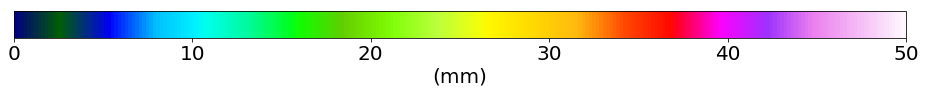

In [24]:
import matplotlib as mpl

fig, ax = plt.subplots(1,1, figsize=(16,0.5))
ax = ax
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
norm = mpl.colors.Normalize(vmin=0, vmax=50)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.

cb1 = mpl.colorbar.ColorbarBase(ax, cmap='gist_ncar',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('(mm)')
plt.show()